# Mathematical programming with Jupyter Notebooks

# The travelling salesman meets Pokemon Go

*Copyright 2016, Pedro Belin Castellucci, All rights reserved.*

*This Notebook is licenced under GLPv3 (https://opensource.org/licenses/GPL-3.0).*

The travelling salesman problem is a classic optimization problem with many variants and applications. An interesting reference is this [book](https://books.google.com.br/books?hl=pt-BR&lr=&id=zfIm94nNqPoC&oi=fnd&pg=PP2&dq=The+Traveling+Salesman+Problem:+A+Computational+Study&ots=k-wNpK12gI&sig=upoiFs9B7ettqr0NzB9e-dnxyok#v=onepage&q=The%20Traveling%20Salesman%20Problem%3A%20A%20Computational%20Study&f=false). In this Notebook we are interested in the most basic version of the problem. A travelling salesman wants to visit a number of potential customers starting at his home. Every customer must be visited exactly once and, by the end of the day, the salesman will return home. The goal of the problem is to find a route for the salesman which minimizes the total distance walking distance.

[Pokemon Go](http://www.pokemongo.com/) is a location-based mobile game developed by Niantic. The game brings to life (in a virtual reality sense) the universe of [Pokemon](https://en.wikipedia.org/wiki/Pok%C3%A9mon). One of the mechanics of the game is the collection of items by the players. This collection can be done by visiting the so-called pokestops. There must be an interval to revisit the same pokestop. Also pokestops are geographically apart and the player has to walk to find another one. 

If a Pokemon Go player wants to visit a series of pokestops in a region close to its home and return, the player and the salesman have a very similar problem. To define the problem more formally, both have a series of points $1, \ldots, n$, which they want to visit optimally, namely, with the minimum walking distance. Let us look at a graphical example.


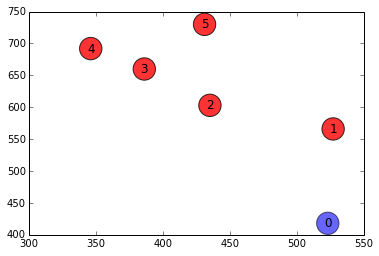

In [16]:
import networkx as nx  # We are using networkx for graph management
import matplotlib.pyplot as plt  # Matplotlib for plotting

%matplotlib inline

# We are creating our stops here
pokeStop = {}
pokeStop[0] = (523, 418)  # This will be our starting point.
pokeStop[1] = (527, 566)
pokeStop[2] = (435, 603)
pokeStop[3] = (386, 660)
pokeStop[4] = (346, 692)
pokeStop[5] = (431, 730)

psLabel = {}
for key, item in pokeStop.items():
    psLabel[key] = key
    
nodes = pokeStop.keys()
pos = pokeStop.values()
            
g = nx.DiGraph()
g.add_nodes_from(nodes)

nx.draw_networkx_nodes(g, list(pos), node_color='b', nodelist=[0], node_size=500, alpha=0.6)
nx.draw_networkx_nodes(g, list(pos), node_color='r', nodelist=range(1, len(pokeStop)), node_size=500, alpha=0.8)
nx.draw_networkx_labels(g, list(pos), labels=psLabel)
plt.show()

Let us assume that the player's home is at point 0 and the pokestops are the points 1 through 5. In this small example, the number of possible routes to visit the pokestops exactly once is $4! = 24$, however, this number grows rapidly if we have more nodes to visit. For 10 nodes we have 362880. In the campus of Sao Carlos of The University of Sao Paulo, Brazil, we have 15 pokestops which gives us 1307674368000 possible routes! It may seem infeasible to find a perfect route. But let us see how Integer Optimization may help us.

We will formulate an integer programming model for our problem and solve it using PuLP and Gurobi. Let $x_{ij}$ be binary variables indicating whether we go from node (pokestop) $i$ to node $j$. Assuming the distance of using route $(i, j)$ is $c_{ij}$ we can define the following model:

$$
\mbox{Min } \sum_{i \in P}\sum_{j \in P} c_{ij}x_{ij},\\
\hspace{-4cm}\mbox{subject to}\\
\sum_{i \in P, i \neq j} x_{ij} = 1, \quad j \in P, \\
\sum_{j \in P, i \neq j} x_{ij} = 1, \quad i \in P, \\
\sum_{(i, j) \in S} x_{ij} \leq |S|-1, \quad S \subset P,\\
x_{ij} \in \{0, 1\},
$$
in which $P$ is a set with the pokestops and the origin. Our objective function is to minimize the costs of the used edges (path from $i$ to $j$). The first and second set of constraints ensure that we will always leave and get to a node, respectively. Then, the third set of constraints eliminates all sub-cycles $S \subset C$. In fact, this sub-cycle eliminating constraints are the "hard" part of our model. The number of these constraints grows exponentialy with the number of nodes in $P$. Although there are other ways to model these constraints, all of them have their drawbacks.

Now, let us implement this model using PuLP, but we will implement for all the 15 pokestops in a University <i>campus</i>. The pokestops were mapped with the help of [Google Maps](maps.google.com), the red dots are the pokestops themselvs, the green dots are the gymnasium and our starting point is the blue dot.

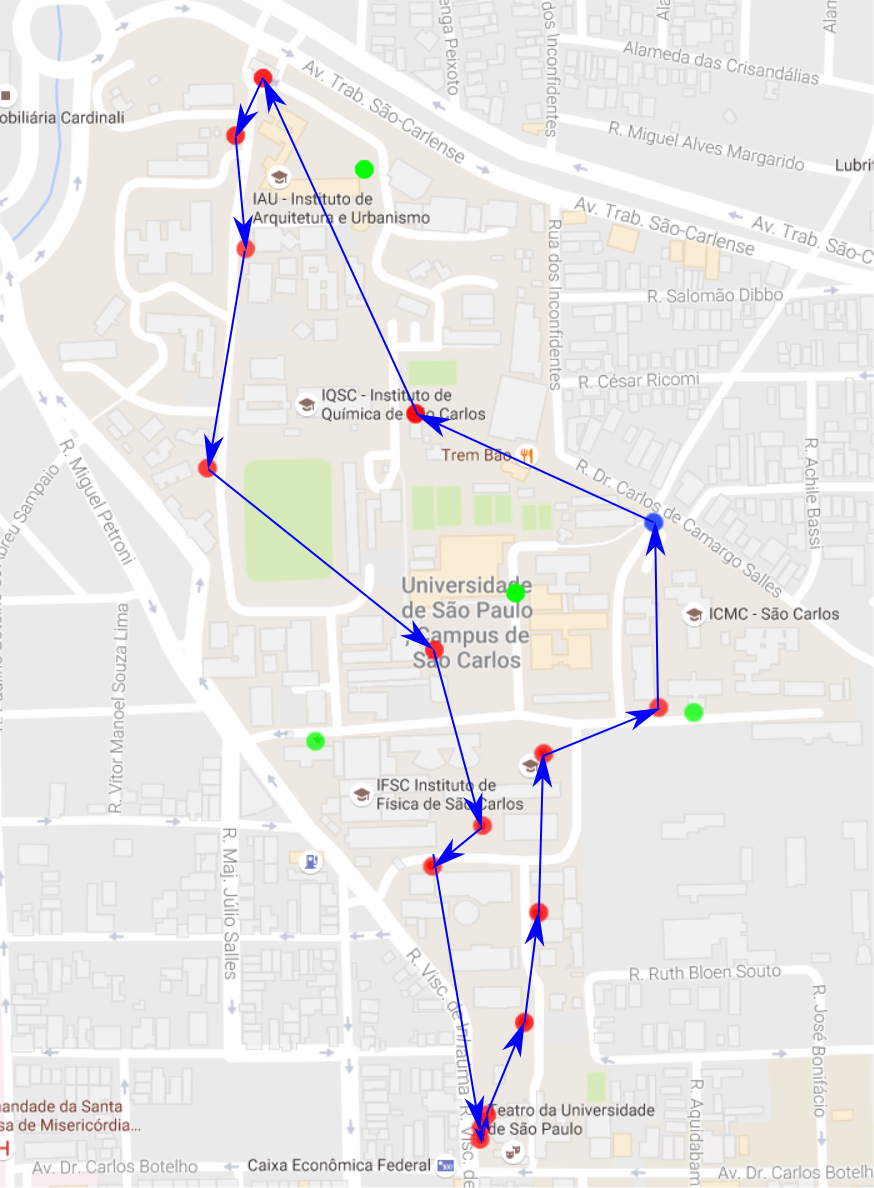

In [17]:
from IPython.core.display import Image, display
display(Image('/home/pbcusp/Pictures/PokeGo_USP_Path.png', width=300, unconfined=True))

We need to map the pokestops into Networkx:

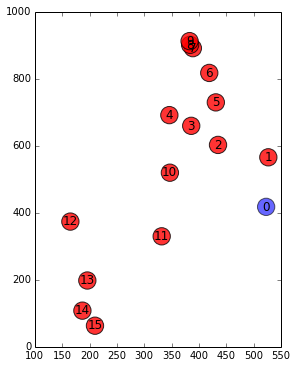

In [18]:
# Mapping the pokestops
pokeStop = {}
pokeStop[0] = (523, 418)
pokeStop[1] = (527, 566)
pokeStop[2] = (435, 603)
pokeStop[3] = (386, 660)
pokeStop[4] = (346, 692)
pokeStop[5] = (431, 730)
pokeStop[6] = (419, 818)
pokeStop[7] = (389, 892)
pokeStop[8] = (384, 902)
pokeStop[9] = (383, 913)
pokeStop[10] = (347, 520)
pokeStop[11] = (332, 330)
pokeStop[12] = (165, 374)
pokeStop[13] = (196, 198)
pokeStop[14] = (187, 108)
pokeStop[15] = (210, 63)

psLabel = {}
for key, item in pokeStop.items():
    psLabel[key] = key
    
nodes = pokeStop.keys()
pos = pokeStop.values()
            
g = nx.DiGraph()
g.add_nodes_from(nodes)

# Plotting:
plt.figure(figsize=(6*0.735, 6))
nx.draw_networkx_nodes(g, list(pos), node_color='b', nodelist=[0], node_size=300, alpha=0.6)
nx.draw_networkx_nodes(g, list(pos), node_color='r', nodelist=range(1, len(pokeStop)), node_size=300, alpha=0.8)
nx.draw_networkx_labels(g, list(pos), labels=psLabel)
plt.show()

Now, we need to calculate the matrix of distances $c_{ij}$. 

In [19]:
import numpy as np

c = np.zeros(shape=(len(pokeStop), len(pokeStop)))

for i in nodes:
    for j in nodes:
            c[i, j] = (
                (pokeStop[i][0] - pokeStop[j][0])**2 + (pokeStop[i][1] - pokeStop[j][1])**2)**0.5

Then, we implement the model using PuLP. However, the number of sub-cycles constraints is more than 130000. Therefore, it may not be a good idea to add all of them <i>a priori</i>. For now, we will just ignore them.

('Gurobi status=', 2)


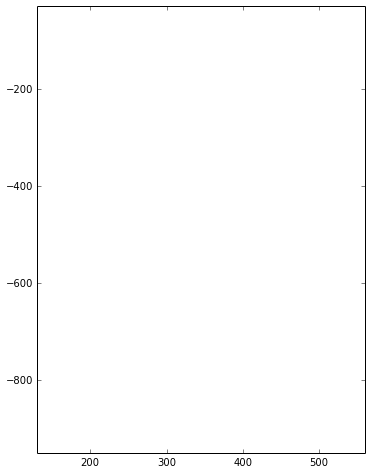

In [20]:
import pulp
model = pulp.LpProblem('TSP-example', pulp.LpMinimize)

x = {}  # Variables

for i in g.nodes():
    for j in g.nodes():
        if i != j:
            x[i, j] = pulp.LpVariable('x_%d_%d' % (i, j), cat='Binary')

# Objective function:
model += sum(x[i, j]*c[i, j] for i in g.nodes() for j in g.nodes() if i != j)

# Constraints:
for j in g.nodes():
    model += sum(x[i, j] for i in g.nodes() if i != j) == 1

for i in g.nodes():
    model += sum(x[i, j] for j in g.nodes() if i != j) == 1

# We are using Gurobi, you may try another solver:
model.solve(pulp.solvers.GUROBI(OutputFlag=0))

# We also want to plot the result:
route = []
for i in g.nodes():
    for j in g.nodes():
        if i != j:
            if x[i, j].value() >= 0.99:
                route.append((i, j))

plt.figure(figsize=(8*0.735, 8))
nx.draw_networkx_edges(g, pos, edgelist=route, node_size=500, node_color='white', width=2, alpha=0.5)
nx.draw_networkx_nodes(g, list(pos), node_color='b', nodelist=[0], node_size=300, alpha=0.7)
nx.draw_networkx_nodes(g, list(pos), node_color='r', nodelist=range(1, len(pokeStop)), node_size=300, alpha=0.85)
nx.draw_networkx_labels(g, list(pos), labels=psLabel)
plt.xlim((130, 560))
plt.ylim((-950, -30))
plt.show()

As expected we have sub-cycles in our solution. We will eliminate them as they appear. Having an optimal solution with sub-cycles, we will find a sub-cycle, add a constraint to remove it resolve our problem. To identify the sub-cycles we will use the following algorithm:

In [21]:
def searchSubcycle(model, x, route, graphSize):
    # We always start at 
    pivot = route[0][0]
    start = route[0][1]
    
    cycleSize = 1
    cycle = [route[0]]
    while start != pivot:
        
        for edge in route:
            if edge[0] == start:
                start = edge[1]
                cycleSize += 1
                cycle.append(edge)
                break
    
    if cycleSize < graphSize:
        # print ('Subcycle found: ', cycle)
        # print ('Adding: ', sum(x[a, b] for a, b in cycle) <= len(cycle) - 1)
        # We eliminate two sub-cycles at once
        model += sum(x[a, b] for a, b in cycle) <= len(cycle) - 1
        model += sum(x[b, a] for a, b in cycle) <= len(cycle) - 1
    
        return True, model
    return False, model

Using our algorithm, we will check if the solution from the solver has any sub-cycle. If it does, we will resolve the model with constraints that eliminate the identified sub-cycle.

In [ ]:
model.solve(pulp.solvers.GUROBI(OutputFlag=0, Threads=4))  # Let us resolve the model
route = []
for i in g.nodes():
    for j in g.nodes():
        if i != j:
            if x[i, j].value() >= 0.99:
                route.append((i, j))

finalSolution, model = searchSubcycle(model, x, route, len(g.nodes()))

solveCount = 0
while finalSolution:  # While there is a sub-cycle in our solution
    model.solve(pulp.solvers.GUROBI(OutputFlag=0))
    
    route = []
    for i in g.nodes():
        for j in g.nodes():
            if i != j:
                if x[i, j].value() >= 0.99:
                    route.append((i, j))
#    print ('Edges in the route: ', route)
#    print ('The cost of the route', model.objective.value())
#    print (sum(c[i, j] for i, j in route))
    
    finalSolution, model = searchSubcycle(model, x, route, len(g.nodes()))
    solveCount += 1
    if solveCount > 1000:
        break
    print("So far, we have called our solver %d times" % (solveCount))


('Gurobi status=', 2)
('Gurobi status=', 2)
So far, we have called our solver 1 times
('Gurobi status=', 2)
So far, we have called our solver 2 times
('Gurobi status=', 2)
So far, we have called our solver 3 times
('Gurobi status=', 2)
So far, we have called our solver 4 times
('Gurobi status=', 2)
So far, we have called our solver 5 times
('Gurobi status=', 2)
So far, we have called our solver 6 times
('Gurobi status=', 2)
So far, we have called our solver 7 times
('Gurobi status=', 2)
So far, we have called our solver 8 times
('Gurobi status=', 2)
So far, we have called our solver 9 times
('Gurobi status=', 2)
So far, we have called our solver 10 times
('Gurobi status=', 2)
So far, we have called our solver 11 times
('Gurobi status=', 2)
So far, we have called our solver 12 times
('Gurobi status=', 2)
So far, we have called our solver 13 times
('Gurobi status=', 2)
So far, we have called our solver 14 times
('Gurobi status=', 2)
So far, we have called our solver 15 times
('Gurobi sta

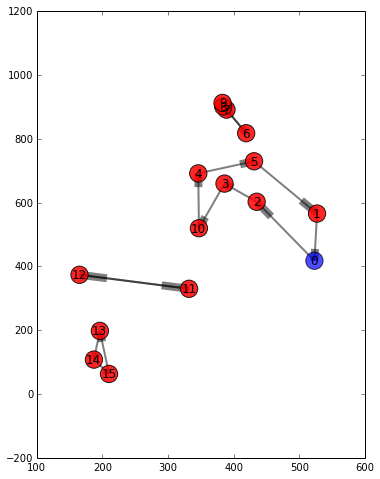

In [25]:


plt.figure(figsize=(8*0.735, 8))
nx.draw_networkx_edges(g, pos, edgelist=route, node_size=500, width=2, alpha=0.5)
nx.draw_networkx_nodes(g, list(pos), node_color='b', nodelist=[0], node_size=300, alpha=0.7)
nx.draw_networkx_nodes(g, list(pos), node_color='r', nodelist=range(1, len(pokeStop)), node_size=300, alpha=0.85)
nx.draw_networkx_labels(g, list(pos), labels=psLabel)
#plt.xlim((130, 560))
#plt.ylim((-950, -30))
plt.show()